#data preprocessing

In [171]:
!pip install prophet

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
from joblib import Parallel, delayed
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
cd /content/drive/Othercomputers/my pc/COURSEWORK/semester2/Forecasting/Project 1

/content/drive/Othercomputers/my pc/COURSEWORK/semester2/Forecasting/Project 1


In [175]:
df = pd.read_csv("LD2011_2014.txt", sep=';', low_memory=False, decimal=',', parse_dates=[0], index_col=0)
df /= 4

In [176]:
df_daily = df.resample('D').sum()
daily_usage = df_daily.melt(ignore_index=False, var_name="Account", value_name="y").reset_index().rename(columns={'index':'ds'})

In [177]:
daily_overall = daily_usage.groupby('ds')['y'].sum().reset_index()

In [178]:
daily_overall

,ds,y
0,2011-01-01,1.713244e+06
1,2011-01-02,2.785336e+06
2,2011-01-03,2.812268e+06
3,2011-01-04,2.866966e+06
4,2011-01-05,2.880437e+06
...,...,...
1457,2014-12-28,4.734025e+06
1458,2014-12-29,4.830825e+06
1459,2014-12-30,4.831542e+06
1460,2014-12-31,4.340759e+06


In [413]:
df_weekly = df.resample('W').sum()
df_weekly = df_weekly.iloc[:-1]

In [414]:
df_weekly.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [415]:
weekly_usage = df_weekly.melt(ignore_index=False, var_name="Account", value_name="y").reset_index().rename(columns={'index':'ds'})

In [416]:
weekly_usage.head()

,ds,Account,y
0,2011-01-02,MT_001,0.0
1,2011-01-09,MT_001,0.0
2,2011-01-16,MT_001,0.0
3,2011-01-23,MT_001,0.0
4,2011-01-30,MT_001,0.0


In [417]:
daily_overall = daily_usage.groupby('ds')['y'].sum().reset_index()

In [418]:
daily_overall.head()

,ds,y
0,2011-01-01,1.713244e+06
1,2011-01-02,2.785336e+06
2,2011-01-03,2.812268e+06
3,2011-01-04,2.866966e+06
4,2011-01-05,2.880437e+06


In [419]:
daily_overall["ds"] = pd.to_datetime(daily_overall["ds"])

In [420]:
weekly_overall = daily_overall.resample('W', on='ds').sum()

In [421]:
weekly_overall = weekly_overall.reset_index()

In [422]:
weekly_overall.head()

,ds,y
0,2011-01-02,4.498581e+06
1,2011-01-09,1.996876e+07
2,2011-01-16,1.966853e+07
3,2011-01-23,1.925900e+07
4,2011-01-30,1.916211e+07


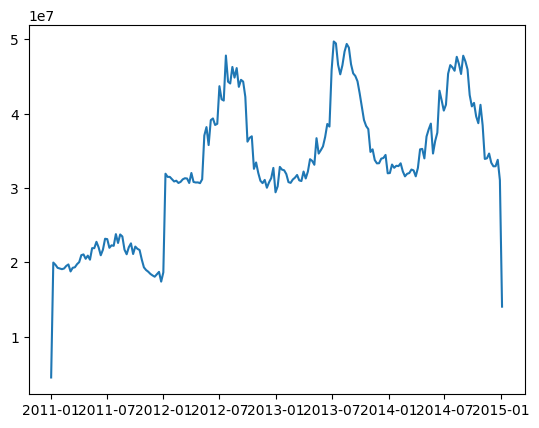

In [423]:
plt.plot(weekly_overall['ds'], weekly_overall['y'])

# Try "Linear" growth for trend


In [424]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [425]:
weekly_overall = daily_overall.resample('W', on='ds').sum()
weekly_overall = weekly_overall.reset_index()
weekly_overall = weekly_overall.iloc[1:]
weekly_overall = weekly_overall.iloc[:-1]

In [426]:
#Train-Test Split (60%-20%-20%)
train_size = int(len(weekly_overall) * 0.6)
val_size = int(len(weekly_overall) * 0.2)


train = weekly_overall.iloc[:train_size]
val = weekly_overall.iloc[train_size:train_size + val_size]
test = weekly_overall.iloc[train_size + val_size:]

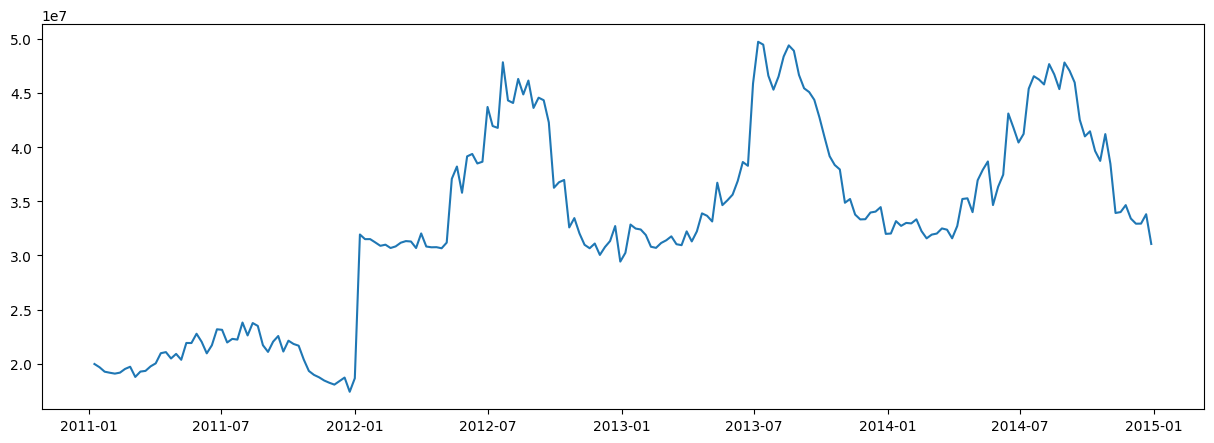

In [427]:
plt.figure(figsize=(15,5))
plt.plot(weekly_overall['ds'], weekly_overall['y'])

In [428]:
weekly_overall_change = weekly_overall.copy()
weekly_overall_change["change"] = weekly_overall_change["y"].diff().abs()
shock = weekly_overall_change[weekly_overall_change["change"] >1e7]
shock

,ds,y,change
53,2012-01-08,3.193123e+07,1.328041e+07


In [429]:
shock_holiday = pd.DataFrame([{"holiday":"bigshock","ds":'2012-01-01','lower_window':0,'ds_upper':'2012-01-08','upper_window':7}])
shock_holiday['ds'] = pd.to_datetime(shock_holiday['ds'])
shock_holiday['ds_upper'] = pd.to_datetime(shock_holiday['ds_upper'])

In [430]:
def evaluate_prophet(scale, monthly_order, weekly_order):

    model = Prophet(
        growth = "linear",
        changepoint_prior_scale=scale,
        daily_seasonality=False,
        weekly_seasonality=False,
        holidays=shock_holiday
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_order)
    model.add_seasonality(name='weekly', period=7, fourier_order=weekly_order)
    model.fit(train)
    #Predict on Validation Set
    future_val = model.make_future_dataframe(periods=len(val), freq='W')  # Weekly

    val_forecast_original = model.predict(future_val)
    val_forecast = val_forecast_original[['ds', 'yhat']].iloc[-len(val):]  # Faster slicing
    mape_val = mape(val.set_index("ds").loc[val_forecast.set_index("ds").index].y, val_forecast.set_index("ds").yhat)
    return (scale, monthly_order, weekly_order, mape_val)

param_grid = [(scale, monthly_order, weekly_order)
              for scale in np.arange(0.2, 1, 0.05)
              for monthly_order in range(5, 15)
              for weekly_order in range(3, 10)]
results = Parallel(n_jobs=-1, backend="loky")(delayed(evaluate_prophet)(*params) for params in param_grid)

best_params = None
best_mape_val = float('inf')
# Find Best Parameters
for scale, monthly_order, weekly_order, mape_val in results:
    if mape_val < best_mape_val:
        best_mape_val = mape_val
        best_params = {'scale': scale, 'monthly_order': monthly_order, 'weekly_order': weekly_order}

print(f"Best Hyperparameters: {best_params}, Best Validation MAPE: {best_mape_val:.2f}%")

Best Hyperparameters: {'scale': 0.35, 'monthly_order': 14, 'weekly_order': 7}, Best Validation MAPE: 4.51%


In [431]:
model = Prophet(changepoint_prior_scale=best_params["scale"],growth="linear",holidays=shock_holiday)
model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params["monthly_order"])
model.add_seasonality(name='weekly', period=7, fourier_order=best_params["weekly_order"])
model.fit(train)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [432]:
#Predict on Validation Set
future_val = model.make_future_dataframe(periods=len(val), freq='W')  # Weekly
val_forecast_original = model.predict(future_val)
val_forecast = val_forecast_original[['ds', 'yhat']].iloc[-len(val):]

In [433]:
mape_val = mape(val.set_index("ds").loc[val_forecast.set_index("ds").index].y, val_forecast.set_index("ds").yhat)
print(f"Overall Validation MAPE: {mape_val:.2f}%")

Overall Validation MAPE: 4.51%


In [434]:
future_test = model.make_future_dataframe(periods=len(test)+len(val), freq='W')
test_forecast_original = model.predict(future_test)
test_forecast = test_forecast_original[['ds', 'yhat']].iloc[-len(test):]
#test_forecast.set_index('ds', inplace=True)

In [435]:
mape_test = mape(test.set_index("ds").loc[test_forecast.set_index("ds").index].y, test_forecast.set_index("ds").yhat)
print(f"Overall Test MAPE: {mape_test:.2f}%")

Overall Test MAPE: 10.75%


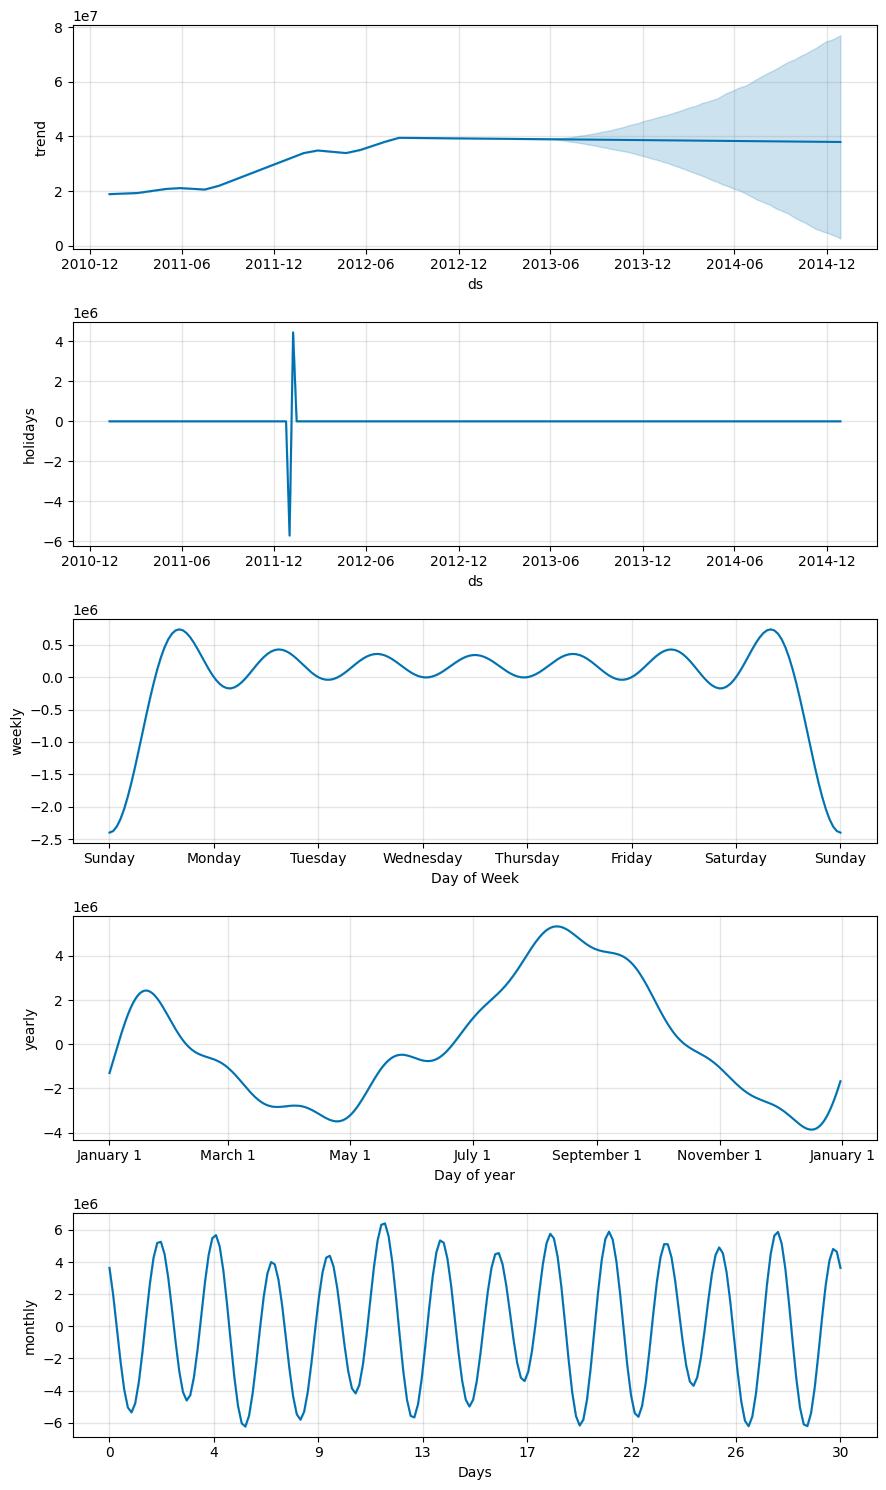

In [436]:
fig = model.plot_components(test_forecast_original)

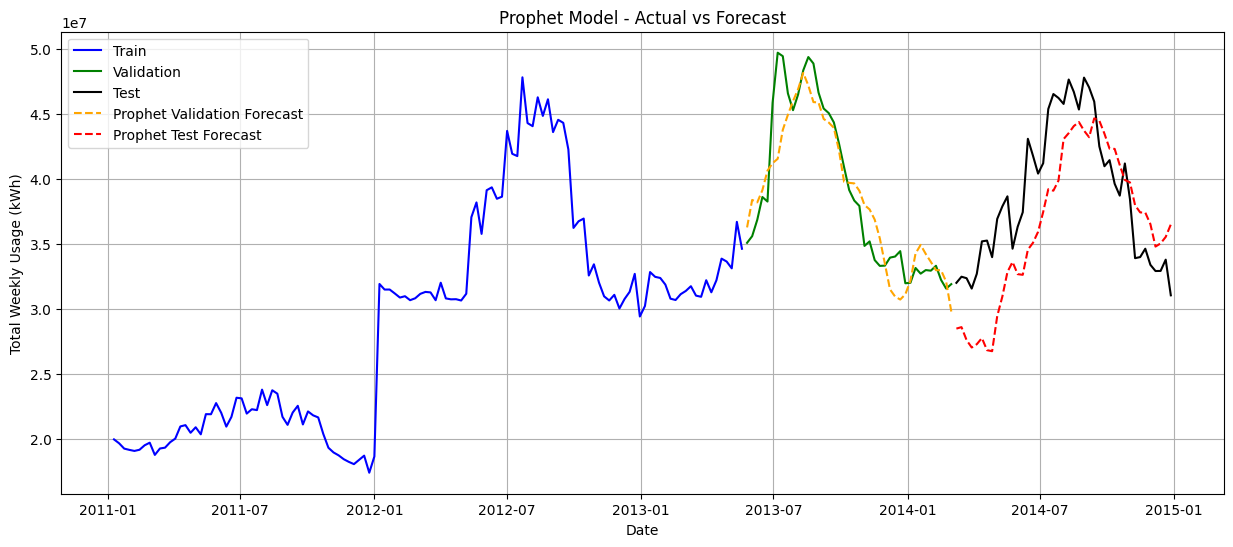

In [437]:
plt.figure(figsize=(15,6))

plt.plot(train['ds'], train['y'], label="Train", color='blue')
plt.plot(val['ds'], val['y'], label="Validation", color='green')
plt.plot(test['ds'], test['y'], label="Test", color='black')

plt.plot(val_forecast.ds, val_forecast['yhat'], label="Prophet Validation Forecast", linestyle='dashed', color='orange')
plt.plot(test_forecast.ds, test_forecast['yhat'], label="Prophet Test Forecast", linestyle='dashed', color='red')

plt.xlabel("Date")
plt.ylabel("Total Weekly Usage (kWh)")
plt.title("Prophet Model - Actual vs Forecast")
plt.legend()
plt.grid()
plt.show()


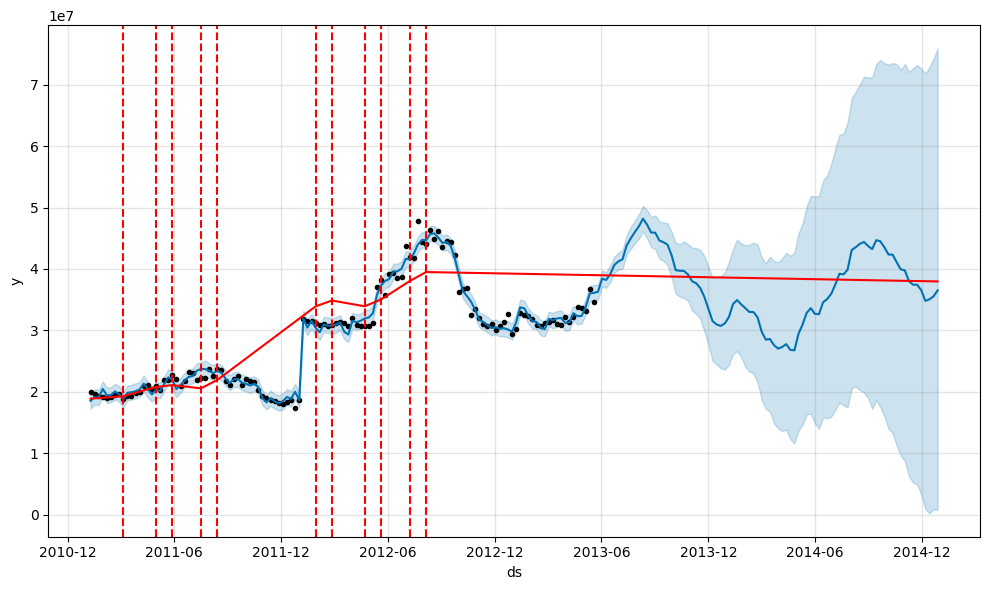

In [438]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(test_forecast_original)
a = add_changepoints_to_plot(fig.gca(), model, test_forecast_original)

In [439]:
# plt.figure(figsize=(15,5))
# plt.scatter(weekly_overall['ds'],weekly_overall["y"])

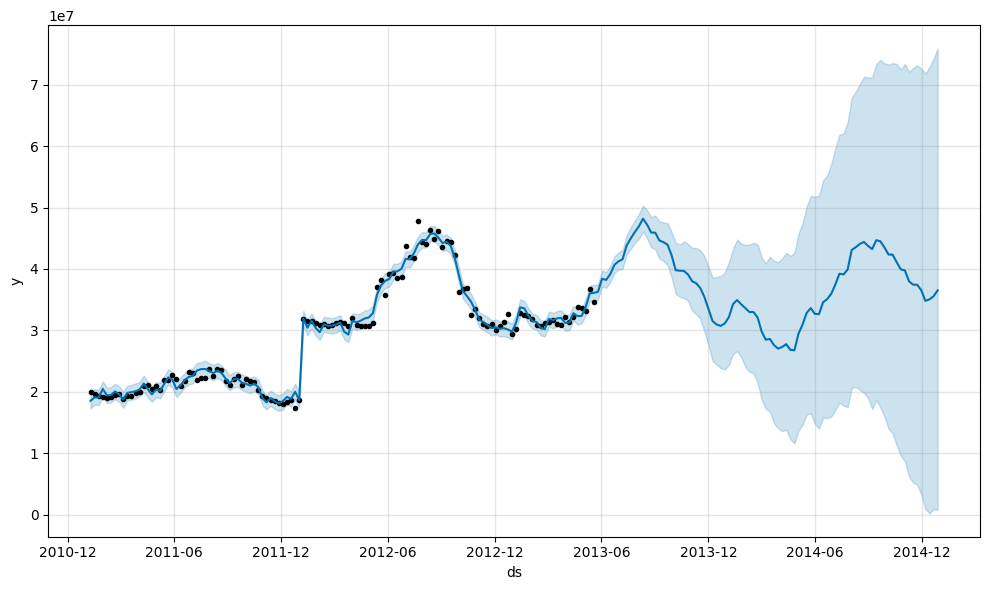

In [440]:
fig = model.plot(test_forecast_original)

Overall MAPE for Test Period 1: 15.61%
Overall MAPE for Test Period 2: 9.00%
Overall MAPE for Test Period 3: 7.28%


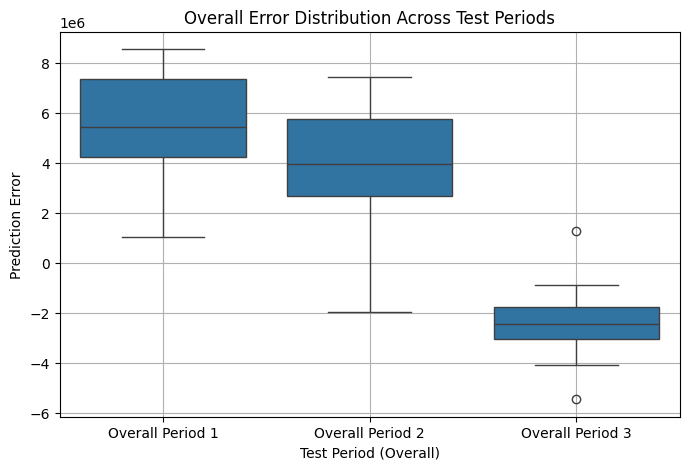

In [441]:
import seaborn as sns
x = np.array_split(test_forecast,3)

mape_results = []
for i,df_test in enumerate(x):
  mape_period = mape(test.set_index("ds").loc[df_test.set_index("ds").index].y, df_test.set_index("ds").yhat)
  mape_results.append(mape_period)
  print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

error_df = []
for i, df_test in enumerate(x):
    period_error = test.set_index("ds").loc[df_test.set_index("ds").index].y - df_test.set_index("ds").yhat
    error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

error_df = pd.concat(error_df)

plt.figure(figsize=(8,5))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Overall Error Distribution Across Test Periods")
plt.xlabel("Test Period (Overall)")
plt.ylabel("Prediction Error")
plt.grid()
plt.show()

# Try "Logistic" growth for trend


In [444]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [445]:
weekly_overall = daily_overall.resample('W', on='ds').sum()
weekly_overall = weekly_overall.reset_index()
weekly_overall = weekly_overall.iloc[1:]
weekly_overall = weekly_overall.iloc[:-1]

In [446]:
train = weekly_overall.iloc[:train_size]
train.loc[:,"cap"] = train["y"].max()*1.1
train.loc[:,"floor"] = train["y"].min()*0.9
val = weekly_overall.iloc[train_size:train_size + val_size]
test = weekly_overall.iloc[train_size + val_size:]

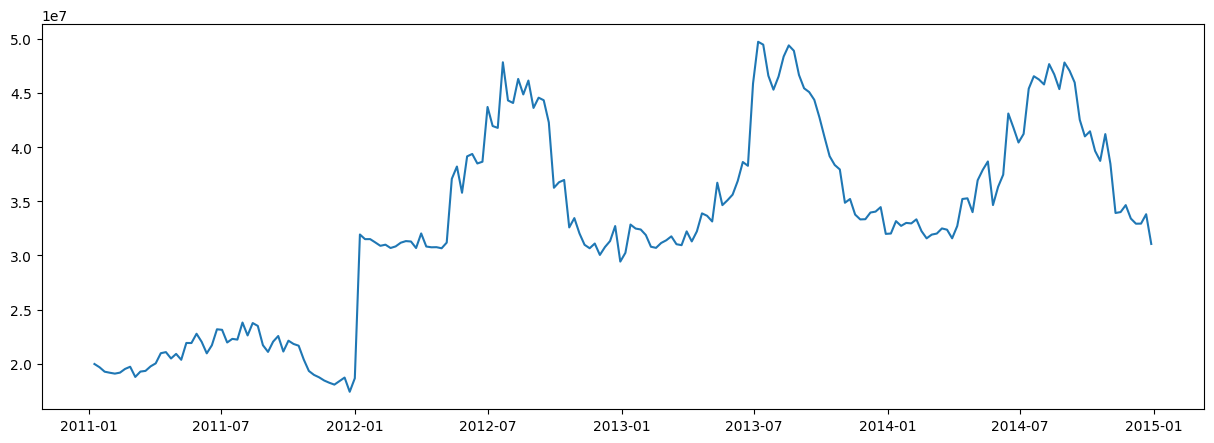

In [447]:
plt.figure(figsize=(15,5))
plt.plot(weekly_overall['ds'], weekly_overall['y'])

In [448]:
weekly_overall_change = weekly_overall.copy()
weekly_overall_change["change"] = weekly_overall_change["y"].diff().abs()
shock = weekly_overall_change[weekly_overall_change["change"] >1e7]
shock

,ds,y,change
53,2012-01-08,3.193123e+07,1.328041e+07


In [449]:
shock_holiday = pd.DataFrame([{"holiday":"bigshock","ds":'2012-01-01','lower_window':0,'ds_upper':'2012-01-08','upper_window':7}])
shock_holiday['ds'] = pd.to_datetime(shock_holiday['ds'])
shock_holiday['ds_upper'] = pd.to_datetime(shock_holiday['ds_upper'])

In [450]:
def evaluate_prophet(scale, monthly_order, weekly_order):

    model = Prophet(
        growth = "logistic",
        changepoint_prior_scale=scale,
        daily_seasonality=False,
        weekly_seasonality=False,
        holidays=shock_holiday
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_order)
    model.add_seasonality(name='weekly', period=7, fourier_order=weekly_order)
    model.fit(train)
    #Predict on Validation Set
    future_val = model.make_future_dataframe(periods=len(val), freq='W')  # Weekly

    future_val["cap"] = train["cap"].unique()[0]
    future_val["floor"] = train["floor"].unique()[0]

    val_forecast_original = model.predict(future_val)
    val_forecast = val_forecast_original[['ds', 'yhat']].iloc[-len(val):]  # Faster slicing
    mape_val = mape(val.set_index("ds").loc[val_forecast.set_index("ds").index].y, val_forecast.set_index("ds").yhat)
    return (scale, monthly_order, weekly_order, mape_val)

param_grid = [(scale, monthly_order, weekly_order)
              for scale in np.arange(0.2, 1, 0.01)
              for monthly_order in range(5, 15)
              for weekly_order in range(3, 10)]
results = Parallel(n_jobs=-1, backend="loky")(delayed(evaluate_prophet)(*params) for params in param_grid)

best_params = None
best_mape_val = float('inf')
# Find Best Parameters
for scale, monthly_order, weekly_order, mape_val in results:
    if mape_val < best_mape_val:
        best_mape_val = mape_val
        best_params = {'scale': scale, 'monthly_order': monthly_order, 'weekly_order': weekly_order}

print(f"Best Hyperparameters: {best_params}, Best Validation MAPE: {best_mape_val:.2f}%")

Best Hyperparameters: {'scale': 0.9800000000000006, 'monthly_order': 11, 'weekly_order': 9}, Best Validation MAPE: 6.88%


In [451]:
train.loc[:,"cap"] = train["y"].max()*1.1
train.loc[:,"floor"] = train["y"].min()*0.9

In [452]:
model = Prophet(changepoint_prior_scale=best_params["scale"],growth="logistic",holidays=shock_holiday)
model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params["monthly_order"])
model.add_seasonality(name='weekly', period=7, fourier_order=best_params["weekly_order"])
model.fit(train)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [453]:
#Predict on Validation Set
future_val = model.make_future_dataframe(periods=len(val), freq='W')  # Weekly

future_val["cap"] = train["cap"].unique()[0]
future_val["floor"] = train["floor"].unique()[0]

val_forecast_original = model.predict(future_val)
val_forecast = val_forecast_original[['ds', 'yhat']].iloc[-len(val):]

In [454]:
mape_val = mape(val.set_index("ds").loc[val_forecast.set_index("ds").index].y, val_forecast.set_index("ds").yhat)
print(f"Overall Validation MAPE: {mape_val:.2f}%")

Overall Validation MAPE: 6.88%


In [455]:
future_test = model.make_future_dataframe(periods=len(test)+len(val), freq='W')

future_test["cap"] = train["cap"].unique()[0]
future_test["floor"] = train["floor"].unique()[0]

test_forecast_original = model.predict(future_test)
test_forecast = test_forecast_original[['ds', 'yhat']].iloc[-len(test):]
#test_forecast.set_index('ds', inplace=True)

In [456]:
mape_test = mape(test.set_index("ds").loc[test_forecast.set_index("ds").index].y, test_forecast.set_index("ds").yhat)
print(f"Overall Test MAPE: {mape_test:.2f}%")

Overall Test MAPE: 6.66%


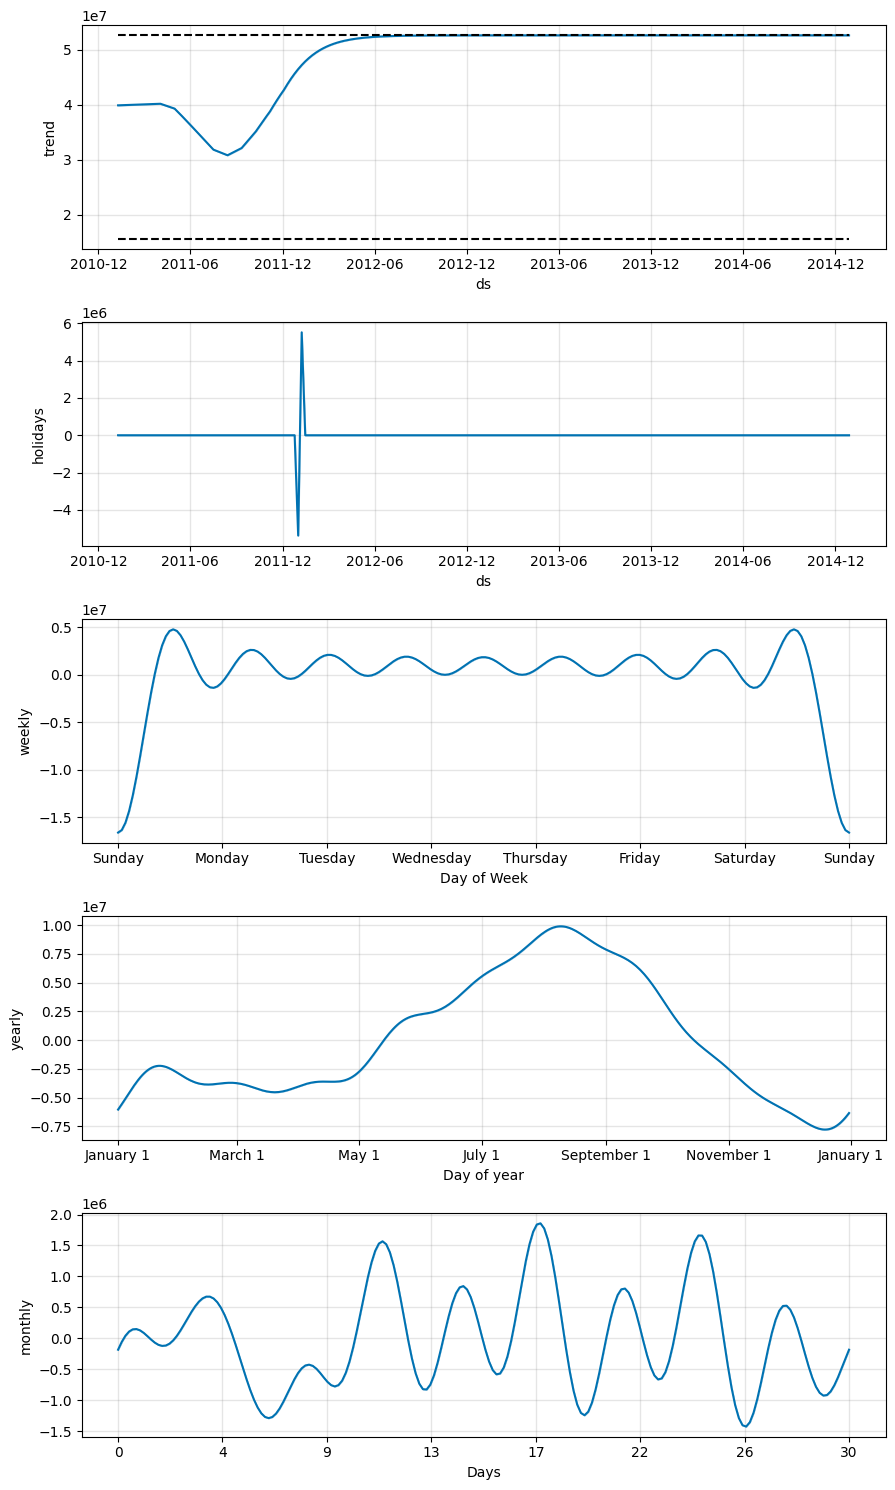

In [457]:
fig = model.plot_components(test_forecast_original)

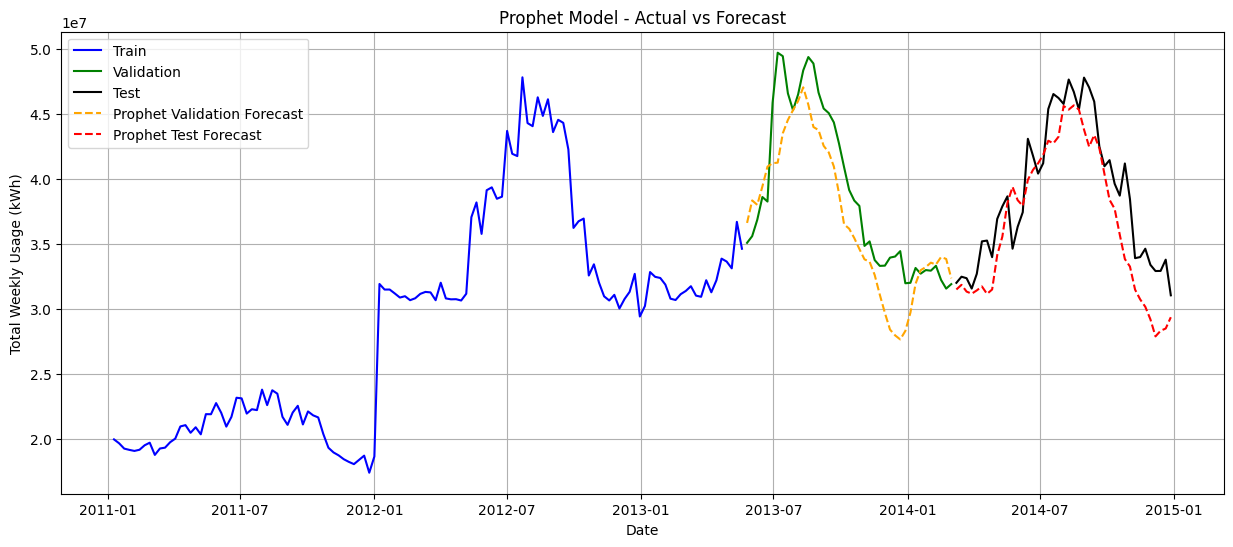

In [458]:
plt.figure(figsize=(15,6))

plt.plot(train['ds'], train['y'], label="Train", color='blue')
plt.plot(val['ds'], val['y'], label="Validation", color='green')
plt.plot(test['ds'], test['y'], label="Test", color='black')

plt.plot(val_forecast.ds, val_forecast['yhat'], label="Prophet Validation Forecast", linestyle='dashed', color='orange')
plt.plot(test_forecast.ds, test_forecast['yhat'], label="Prophet Test Forecast", linestyle='dashed', color='red')

plt.xlabel("Date")
plt.ylabel("Total Weekly Usage (kWh)")
plt.title("Prophet Model - Actual vs Forecast")
plt.legend()
plt.grid()
plt.show()


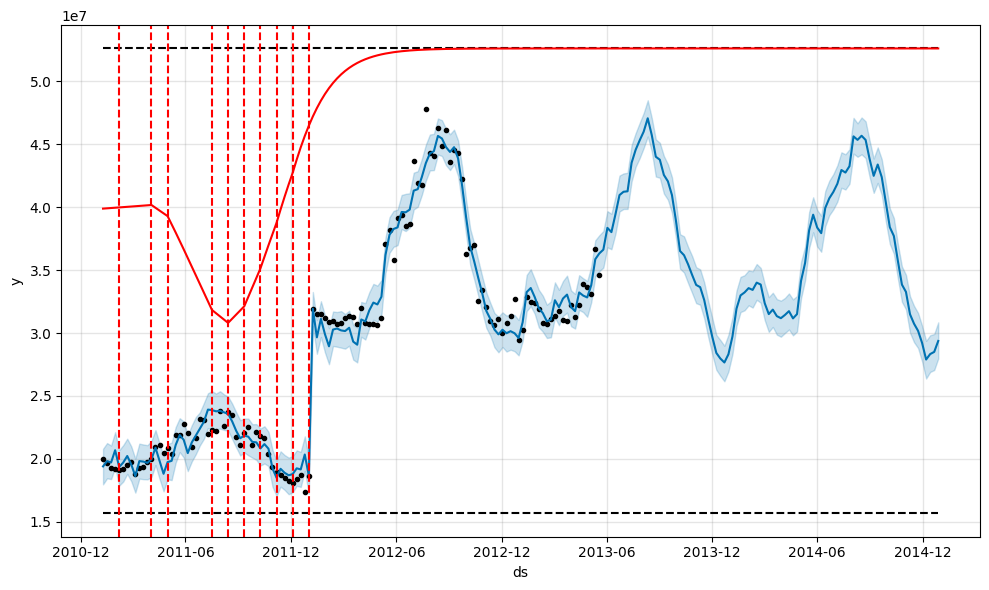

In [459]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(test_forecast_original)
a = add_changepoints_to_plot(fig.gca(), model, test_forecast_original)

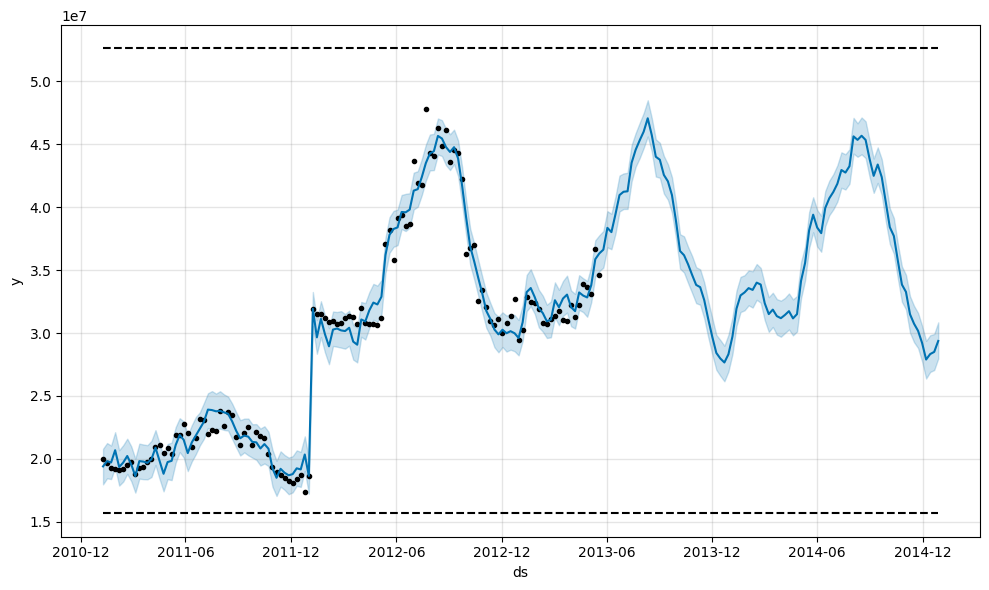

In [460]:
fig = model.plot(test_forecast_original)

Overall MAPE for Test Period 1: 5.58%
Overall MAPE for Test Period 2: 4.11%
Overall MAPE for Test Period 3: 10.38%


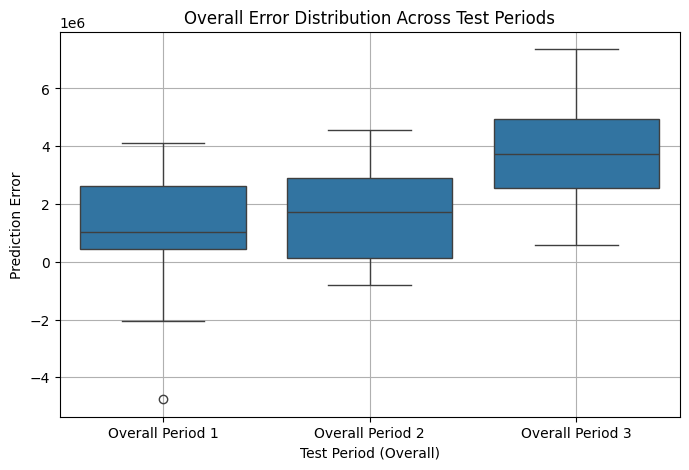

In [461]:
import seaborn as sns
x = np.array_split(test_forecast,3)

mape_results = []
for i,df_test in enumerate(x):
  mape_period = mape(test.set_index("ds").loc[df_test.set_index("ds").index].y, df_test.set_index("ds").yhat)
  mape_results.append(mape_period)
  print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

error_df = []
for i, df_test in enumerate(x):
    period_error = test.set_index("ds").loc[df_test.set_index("ds").index].y - df_test.set_index("ds").yhat
    error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

error_df = pd.concat(error_df)

plt.figure(figsize=(8,5))
sns.boxplot(x="Test Period", y="Error", data=error_df)
plt.title("Overall Error Distribution Across Test Periods")
plt.xlabel("Test Period (Overall)")
plt.ylabel("Prediction Error")
plt.grid()
plt.show()